In [1]:
import numpy as np
import matplotlib as mp
import matplotlib.pyplot as plt
import scipy.io as sio
from scipy import ndimage
import progressbar
import HbXConcentrations as hbx

In [2]:
# Auxiliary functions

def loadMatStruct (fileName, keyName, index=1):
    '''
    Load MatLab generated MC simulations
    
    fileName: input filename
    keyName: dictionary key to load
    index: index to load inside the keyName
    
    '''
    rawMat = sio.loadmat(fileName, squeeze_me=True)[keyName]
    imgArrMat = []

    for i in range(np.shape(rawMat)[0]):
        for j in range(np.shape(rawMat)[1]):
            imgArrMat.append(rawMat[i,j].item()[index])

    return np.asarray(imgArrMat), np.shape(np.asarray(imgArrMat))

def cropAroundPosition(inImage, xCenter, yCenter, xSize, ySize):
    '''
    Crop an image around a (x,y) center
    
    inImage: input image
    xCenter, yCenter: center around cropping
    xSize, ySize: cropping size    
    '''    
    
    import numpy as np
    
    imageCropped = np.full((xSize, ySize), fill_value=np.nan)
    xSizeImage, ySizeImage = np.shape(inImage)
    
    for x in range(xSize):
        for y in range(ySize):
            xDiff = int(xSize/2-x)
            yDiff = int(ySize/2-y)            
            
            if xCenter-xDiff >= 0 and yCenter-yDiff >= 0: 
                if xCenter-xDiff < xSizeImage and yCenter-yDiff < ySizeImage:
                    imageCropped[x][y] = inImage[xCenter-xDiff][yCenter-yDiff]

    return imageCropped

def gaussian2D(xSize, ySize, x0In, y0In, sigma, muu, contrast=10, baseValue=0):
    '''
    Generate 2D gaussian profile around (x0In, y0In) and store in an array of size (xSize, ySize)
    '''
    #import numpy as np

    x0 = xSize/2-x0In
    y0 = ySize/2-y0In

    # Initializing value of x-axis and y-axis
    # in the range -1 to 1
    x, y = np.meshgrid(np.linspace(-ySize/2+y0, ySize/2+y0, ySize),
                       np.linspace(-xSize/2+x0, ySize/2+x0, xSize))
    dst = np.sqrt(x*x+y*y)

    # Calculating Gaussian array
    gauss = np.exp(-((dst-muu)**2 / (2.0 * sigma**2)))
    if contrast != 0:
        gauss = (np.abs(gauss-1/contrast) + (gauss-1/contrast)) / 2
        gauss[gauss == 0] = baseValue
        gauss = gauss/np.max(gauss)
    return gauss


def maxPosCm(in_array, smooth=40, threshold=0.6):
    '''
        Find maximum of the 2d array by finding the center of
        mass of a discretized image

        in_array: input array
        smooth: size of the kernel for the gaussian filter used in
        smoothing
        threshold [0-1]: factor of the maximum to consider for the
        discretization
    '''
    in_array = np.nan_to_num(in_array)

    if len(in_array) > 0:
        # Smooth image
        if smooth > 0:
            im_temp = fft_gauss(in_array, smooth)[0]
        else:
            im_temp = in_array

        del in_array

        # Find the maximim of the smoothed image
        max_im = np.max(im_temp)

        # Discretize the image in two levels
        im_temp[im_temp < max_im*threshold] = 0
        im_temp[im_temp > max_im*threshold] = 1

        # Find the center of mass
        #cm = ndimage.measurements.center_of_mass(im_temp)
        cm = ndimage.center_of_mass(im_temp)
        return[int((cm[1])), int((cm[0]))]


def recon2D(images, centers, weights=[], method="mean"):
    '''
    Topografic 2D reconstrucion
    
    images: normalized and processed images
    centers: centers position of images
    weights: matrix of weights for the averaging of pixels. Should be of the same size as each image.
    
    Returns the final reconstructed image and 2D array with the number of images that constribute to each pixel.
    '''
    
    maxCenters = int(np.amax(centers))  
    reconShape = (np.shape(images[0])[0]+maxCenters, np.shape(images[0])[1]+maxCenters) #TODO: Can be improved...
    
    imageReconBackLevel = 0

    if method == "mean":
        imageReconTemp = np.full(reconShape, fill_value=imageReconBackLevel, dtype=float)
        imageReconCount = np.zeros(reconShape)
    
    elif method == "median":
        imageReconTemp = np.full((np.shape(images)[0],reconShape[0],reconShape[1]), fill_value=np.nan, dtype=float)
    
    
    xSize,ySize = np.shape(images[0])
    
    if np.shape(weights)[0]<1:
        weights = np.full((xSize,ySize), fill_value=1, dtype=float)
        
    for i, image in enumerate(progressbar.progressbar(images)):
        centerX = int(centers[i][1])
        centerY = int(centers[i][0])
        #xSize,ySize = np.shape(image)
       
        # For each pixel in imageDiv
        for x in np.arange(xSize):
            for y in np.arange(ySize):
                if ~np.isnan(image[x][y]):
                    posX = centerX + x
                    posY = centerY + y
                    
                    if method == "mean":
                        try:
                            imageReconTemp[posX][posY] += image[x][y]*weights[x][y]
                            imageReconCount[posX][posY] += weights[x][y]
                        except Exception:
                            print("Error in image {}... skipping.".format(i))
                            pass
                    elif method == "median":
                        try:
                            imageReconTemp[i][posX][posY] = image[x][y]
                        except Exception:
                            print("Error in image {}... skipping.".format(i))
                            pass
                        
    if method == "mean":                
        imageRecon = imageReconTemp/imageReconCount
        return imageRecon, imageReconCount
    if method == "median":
        imageRecon = np.nanmedian(imageReconTemp, axis=0)
        return imageRecon, []

In [3]:
# Load sample MC simulations

imagesMC1, shapeImagesMC1 = loadMatStruct("MC2Inc660_2.mat", "flux")
imagesMC2, shapeImagesMC2 = loadMatStruct("MC2Inc660_2.mat", "flux")

In [4]:
# Compute source centers

centersPos1 = np.empty((shapeImagesMC1[0],2))
centersPos2 = np.empty((shapeImagesMC2[0],2))

for i in range(shapeImagesMC1[0]):
    centersPos1[i] = maxPosCm(imagesMC1[i], smooth=0)
    
for i in range(shapeImagesMC2[0]):
    centersPos2[i] = maxPosCm(imagesMC2[i], smooth=0)

In [5]:
# Compute centered crops

imagesCentered1 = []
imagesCentered2 = []

cropSizeX = 70
cropSizeY = 70

for i, image in enumerate(imagesMC1):
    imageTemp = cropAroundPosition(image, round(centersPos1[i][1]), round(centersPos1[i][0]), cropSizeX, cropSizeY) 
    imagesCentered1.append(imageTemp) 

for i, image in enumerate(imagesMC2):
    imageTemp = cropAroundPosition(image, round(centersPos2[i][1]), round(centersPos2[i][0]), cropSizeX, cropSizeY) 
    imagesCentered2.append(imageTemp)  

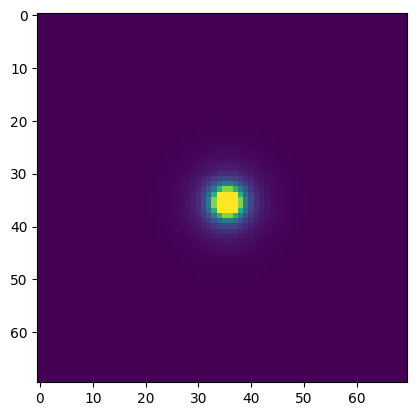

In [6]:
# Generate background normalization image

back1 = np.nanmean(imagesCentered1, axis=0)
back2 = np.nanmean(imagesCentered2, axis=0)
plt.imshow(back1)

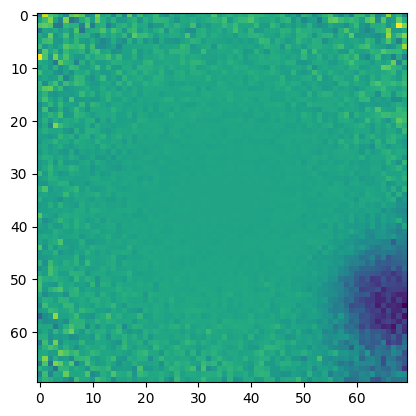

In [7]:
# Compute normalized crops

imagesDiv1 = imagesCentered1/back1
imagesDiv2 = imagesCentered2/back2
plt.imshow(imagesDiv1[12])

In [8]:
# Generate 2D reconstruction using gaussian weights

gaussianWeights = gaussian2D(cropSizeX,cropSizeY,int(cropSizeX/2),int(cropSizeX/2),sigma=10,muu=0,contrast=0)

recon2DAll1, recon2DAllCount1 = recon2D(imagesDiv1, centersPos1, weights=gaussianWeights)
recon2DAll2, recon2DAllCount2 = recon2D(imagesDiv2, centersPos2, weights=gaussianWeights)


  0% (0 of 36) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 13% (5 of 36) |###                      | Elapsed Time: 0:00:00 ETA:  00:00:00
 27% (10 of 36) |######                  | Elapsed Time: 0:00:00 ETA:   0:00:00
 41% (15 of 36) |##########              | Elapsed Time: 0:00:00 ETA:   0:00:00
 55% (20 of 36) |#############           | Elapsed Time: 0:00:00 ETA:   0:00:00
 69% (25 of 36) |################        | Elapsed Time: 0:00:00 ETA:   0:00:00
 83% (30 of 36) |####################    | Elapsed Time: 0:00:00 ETA:   0:00:00
 97% (35 of 36) |####################### | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (36 of 36) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
/tmp/ipykernel_139260/2889539408.py:161: RuntimeWarning: invalid value encountered in divide
  imageRecon = imageReconTemp/imageReconCount
  0% (0 of 36) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 13% (5 of 36) |###                      | Elapsed Time: 0:00

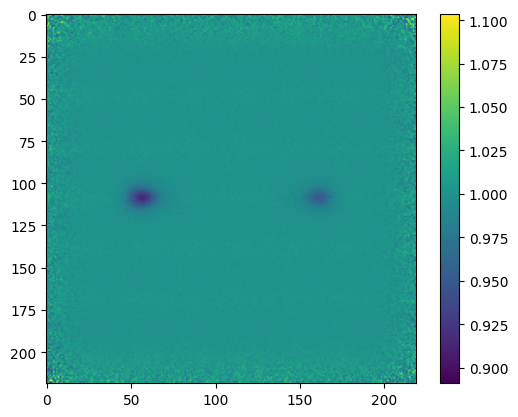

In [9]:
recon2DCrop1 = recon2DAll1[50:,50:]
plt.imshow(recon2DCrop1)
plt.colorbar()

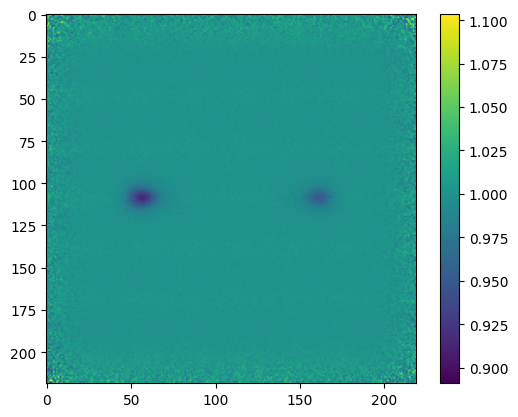

In [10]:
recon2DCrop2 = recon2DAll2[50:,50:]
plt.imshow(recon2DCrop2)
plt.colorbar()

In [11]:
imRaw = np.zeros((np.shape(recon2DCrop1)[0], np.shape(recon2DCrop1)[1], 2))
imRaw[:,:,0] = recon2DCrop1
imRaw[:,:,1] = recon2DCrop2

lambdas = [660, 785, 830]

cropSize = 100

HbXMaps_2D = hbx.MamoRef_dHbX(imRaw, lambdas, centersPos1, cropSize, cropSize)
    
desOxyMap_2D = HbXMaps_2D[:,:,1]
OxyMap_2D = HbXMaps_2D[:,:,0]
TotMap_2D = desOxyMap_2D + OxyMap_2D

Step 1/2...


100%|██████████| 100/100 [00:06<00:00, 16.47it/s]


Step 2/2...


100%|██████████| 36/36 [00:11<00:00,  3.13it/s]
/home/nicolas/Bionirs/MamoRefCodePublic/HbXConcentrations.py:159: RuntimeWarning: invalid value encountered in divide
  LL = LL/cont


In [16]:
#desOxyMap_2D_filtered = ndimage.median_filter(desOxyMap_2D,0)
#OxyMap_2D_filtered = ndimage.median_filter(OxyMap_2D,0)

desOxyMap_2D_filtered = desOxyMap_2D
OxyMap_2D_filtered = OxyMap_2D

desOxyMap_2D_filtered[desOxyMap_2D_filtered==np.nan] = 0
OxyMap_2D_filtered[OxyMap_2D_filtered==np.nan] = 0

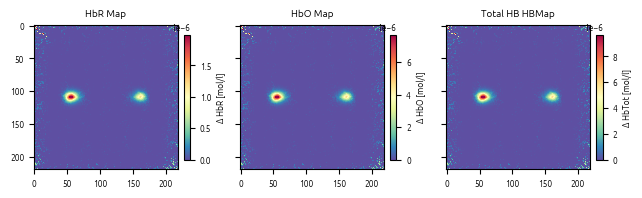

In [20]:
colorMap = "Spectral_r"
    
font = {'family' : 'ubuntu',
        'weight' : 'regular',
        'size'   : 6}

mp.rc('font', **font)

figSats, ((DesOxy, Oxy, Tot)) = plt.subplots(1, 3, sharex=True, sharey=True)

maxDev = 5   

sd = np.nanstd(desOxyMap_2D_filtered)
median = np.nanmedian(desOxyMap_2D_filtered)
vmax = median + maxDev * sd
vmin = 0

figDesOxy = DesOxy.imshow(desOxyMap_2D_filtered, vmin=vmin, vmax=vmax, cmap=mp.colormaps[colorMap])
c1 = figSats.colorbar(figDesOxy, ax=DesOxy, fraction=0.04, pad=0.04)
c1.set_label("Δ HbR [mol/l]")

sd = np.nanstd(OxyMap_2D_filtered)
median = np.nanmedian(OxyMap_2D_filtered)
vmax = median + maxDev * sd
vmin = 0


figOxy = Oxy.imshow(OxyMap_2D_filtered, vmin=vmin, vmax=vmax, cmap=mp.colormaps[colorMap])
c2 = figSats.colorbar(figOxy, ax=Oxy, fraction=0.04, pad=0.04)
c2.set_label("Δ HbO [mol/l]")


TotMap_2D = desOxyMap_2D_filtered + OxyMap_2D_filtered

sd = np.nanstd(TotMap_2D)
median = np.nanmedian(TotMap_2D)
vmax = median + maxDev * sd
vmin = 0


figTot = Tot.imshow(TotMap_2D, vmin=vmin, vmax=vmax, cmap=mp.colormaps[colorMap])
c3 = figSats.colorbar(figTot, ax=Tot, fraction=0.04, pad=0.04)
c3.set_label("Δ HbTot [mol/l]")


DesOxy.set_title("HbR Map")

Oxy.set_title("HbO Map")

Tot.set_title("Total HB HBMap")


figSats.tight_layout()

figSats.savefig("MC2Incs_HbXMaps.png", dpi=300)